In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.6.0-dev20210602


In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    
    plt.xlabel("Time")
    plt.ylabel("Value")
    
    plt.grid(True)

In [4]:
def trend(time, slope=0):
    return slope*time

In [5]:
def seasonal_pattern(season_time):
    return np.where(
        season_time < 0.4,
        np.cos(season_time*2*np.pi),
        1/np.exp(3*season_time)
    )

In [6]:
def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time+phase) % period)/period
    return amplitude * seasonal_pattern(season_time)

In [7]:
def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [8]:
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)

In [10]:
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

In [11]:
# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

In [12]:
split_time = 1000

time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [13]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

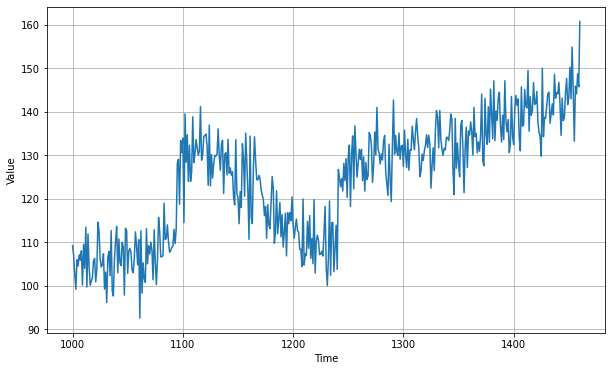

In [14]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

In [15]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
      
    return dataset

In [17]:
dataset = windowed_dataset(
    x_train,
    window_size,
    batch_size,
    shuffle_buffer_size
)

In [18]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape = [window_size], activation = "relu"),
    tf.keras.layers.Dense(10, activation = "relu"),
    tf.keras.layers.Dense(1)
])

In [19]:
model.compile(
    loss = "mse",
    optimizer = tf.keras.optimizers.SGD(
        learning_rate = 1e-6,
        momentum = 0.9
    )
)

In [20]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

In [21]:
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

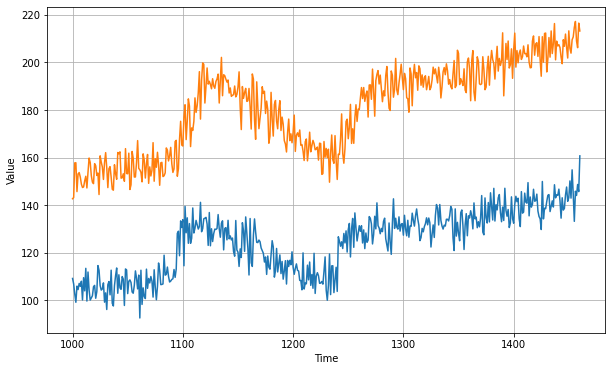

In [22]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [23]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

56.53628

In [26]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20)
)

optimizer = tf.keras.optimizers.SGD(
    learning_rate = 1e-8, 
    momentum = 0.9
)

In [27]:
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

(1e-08, 0.001, 0.0, 300.0)

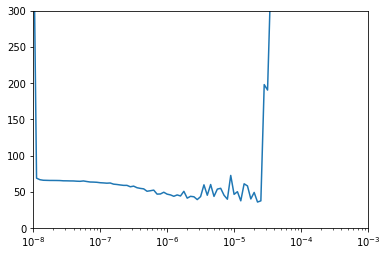

In [30]:
learning_rs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(learning_rs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [31]:
window_size = 30
dataset = windowed_dataset(
    x_train,
    window_size,
    batch_size,
    shuffle_buffer_size
)

In [35]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

In [36]:
optimizer = tf.keras.optimizers.SGD(
    learning_rate = 8e-6,
    momentum = 0.9
)
model.compile(loss = "mse", optimizer = optimizer)

In [37]:
history = model.fit(dataset, epochs=500, verbose=1)

Epoch 1/500
31/31 [==============================] - 0s 962us/step - loss: 4308.8882
Epoch 2/500
31/31 [==============================] - 0s 942us/step - loss: 4230.9971
Epoch 3/500
31/31 [==============================] - 0s 885us/step - loss: 4175.2471
Epoch 4/500
31/31 [==============================] - 0s 928us/step - loss: 603.1865
Epoch 5/500
31/31 [==============================] - 0s 995us/step - loss: 67.0604
Epoch 6/500
31/31 [==============================] - 0s 864us/step - loss: 54.2013
Epoch 7/500
31/31 [==============================] - 0s 933us/step - loss: 56.1111
Epoch 8/500
31/31 [==============================] - 0s 964us/step - loss: 48.5913
Epoch 9/500
31/31 [==============================] - 0s 970us/step - loss: 47.9889
Epoch 10/500
31/31 [==============================] - 0s 946us/step - loss: 48.7304
Epoch 11/500
31/31 [==============================] - 0s 983us/step - loss: 44.7778
Epoch 12/500
31/31 [==============================] - 0s 930us/step - loss: 43

31/31 [==============================] - 0s 929us/step - loss: 38.5910
Epoch 195/500
31/31 [==============================] - 0s 938us/step - loss: 34.5646
Epoch 196/500
31/31 [==============================] - 0s 932us/step - loss: 35.2228
Epoch 197/500
31/31 [==============================] - 0s 944us/step - loss: 33.9359
Epoch 198/500
31/31 [==============================] - 0s 949us/step - loss: 39.4077
Epoch 199/500
31/31 [==============================] - 0s 946us/step - loss: 34.3058
Epoch 200/500
31/31 [==============================] - 0s 904us/step - loss: 37.8609
Epoch 201/500
31/31 [==============================] - 0s 874us/step - loss: 47.6669
Epoch 202/500
31/31 [==============================] - 0s 944us/step - loss: 39.5276
Epoch 203/500
31/31 [==============================] - 0s 888us/step - loss: 42.6479
Epoch 204/500
31/31 [==============================] - 0s 926us/step - loss: 37.2668
Epoch 205/500
31/31 [==============================] - 0s 909us/step - loss: 32

31/31 [==============================] - 0s 941us/step - loss: 35.5793
Epoch 387/500
31/31 [==============================] - 0s 899us/step - loss: 31.9402
Epoch 388/500
31/31 [==============================] - 0s 879us/step - loss: 32.9731
Epoch 389/500
31/31 [==============================] - 0s 948us/step - loss: 33.1723
Epoch 390/500
31/31 [==============================] - 0s 942us/step - loss: 35.1036
Epoch 391/500
31/31 [==============================] - 0s 956us/step - loss: 32.5637
Epoch 392/500
31/31 [==============================] - 0s 979us/step - loss: 35.2122
Epoch 393/500
31/31 [==============================] - 0s 985us/step - loss: 31.3503
Epoch 394/500
31/31 [==============================] - 0s 957us/step - loss: 37.9078
Epoch 395/500
31/31 [==============================] - 0s 978us/step - loss: 34.0864
Epoch 396/500
31/31 [==============================] - 0s 948us/step - loss: 45.4010
Epoch 397/500
31/31 [==============================] - 0s 981us/step - loss: 35

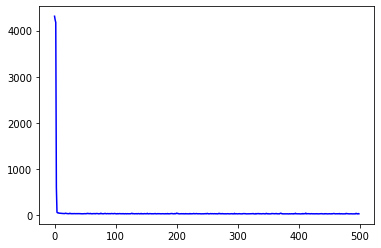

In [39]:
loss = history.history['loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label = 'Training Loss')
plt.show()

[44.77784729003906, 43.62845993041992, 41.05989074707031, 42.2069206237793, 39.467098236083984, 37.75363540649414, 38.499725341796875, 40.275333404541016, 46.69076156616211, 42.137306213378906, 39.291927337646484, 37.61256790161133, 38.333274841308594, 36.18083953857422, 36.93026351928711, 45.17783737182617, 41.344486236572266, 34.6986198425293, 37.8147087097168, 38.38350296020508, 34.90049362182617, 36.75904083251953, 38.98390197753906, 37.411190032958984, 36.12781524658203, 37.30234909057617, 36.40951919555664, 37.899383544921875, 36.169898986816406, 38.4627799987793, 36.107784271240234, 37.53660202026367, 36.45612335205078, 34.448089599609375, 35.027687072753906, 34.05606460571289, 35.57175827026367, 34.87713623046875, 34.941219329833984, 37.43178939819336, 36.078922271728516, 34.8363151550293, 35.278987884521484, 40.640506744384766, 43.30246353149414, 37.63845443725586, 40.103607177734375, 36.935062408447266, 37.083778381347656, 41.746219635009766, 35.81006622314453, 35.75528335571

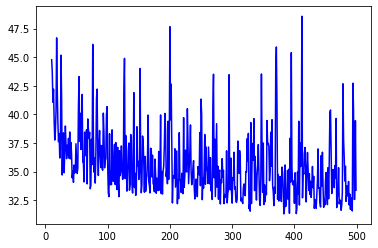

In [40]:
loss = history.history['loss']
epochs = range(10, len(loss))

plot_loss = loss[10:]
print(plot_loss)

plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

In [41]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

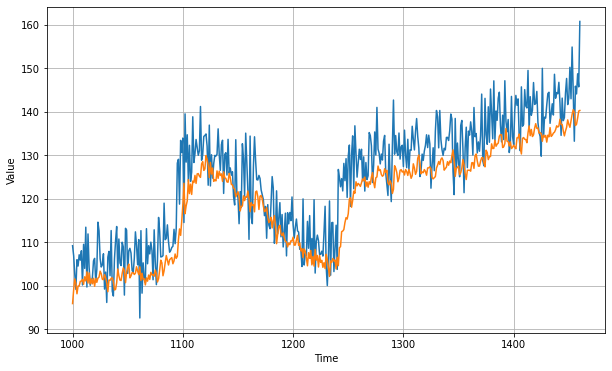

In [42]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [43]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.172999